In [6]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GOOGLE_API_KEY")
_set_env("GROQ_API_KEY")
_set_env("TAVILY_API_KEY")
# _set_env("LANGSMITH_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [7]:
from langchain_core.pydantic_v1 import BaseModel, Field


class IsVideoGame(BaseModel):
    '''Is the provided query directly related to video games, video game culture, \
or any specific aspect of video gaming, including but not limited to game titles, genres, \
platforms, gaming technology, game development, or the gaming community? Answer in boolean value only True or False. '''
    val: bool
    # , description="Answer in boolean value only 'True' or 'False'.")

In [8]:
from langchain_community.tools.tavily_search.tool import TavilySearchResults

search_tool = TavilySearchResults(
    max_results=3,
    description= "A search engine optimized for comprehensive, accurate, and trusted results. \
Useful for when you need to answer questions about current events. Use this tool when asked regarding latest or\
Specific information about video games related topic which you don't know. \
Input should be a search query.",
    # search_depth="advanced",
    # include_answer=True,
    # include_raw_content=True,
    # include_images=True,
)

In [9]:
from typing import Annotated, Literal
import json
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
# llm = ChatGroq()
llm = llm.bind_tools([search_tool])

model = ChatGroq(model="llama3-groq-8b-8192-tool-use-preview")
structured_llm = model.with_structured_output(IsVideoGame)


class State(TypedDict):
    
    is_video_game: bool
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [10]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: State) -> State:
        message = inputs["messages"][-1]
        outputs = []
        for tool_call in message.tool_calls:

            print("--TOOL CALLED:", tool_call["name"], "--")
            
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[search_tool])
graph_builder.add_node("search", tool_node)

In [11]:
def is_topic_related_to_video_games(state: State) -> State:
    user_query = state["messages"][-1].content

    print("--TOPIC ANALYSIS--")
    
    ans = structured_llm.invoke(user_query)

    # if ans.parsing_error:
    #     state["is_video_game"] = ans['raw']['additional_kwargs']['tool_calls'][0]['function']['arguments']['val'].lower() == 'true'
    # else :
    #     state["is_video_game"] = ans['parsed'].val
    state["is_video_game"] = ans.val
    return state
    
graph_builder.add_node("topic_analysis", is_topic_related_to_video_games)

In [12]:
def chatbot(state: State) -> State:
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [13]:
def not_video_game(state: State) -> State:
    return {"messages": [AIMessage(content= "I'm sorry, I can't help you with that. Please Ask me querys regarding video games.", 
                                   id=state["messages"][-1].id)]}
    


graph_builder.add_node("not_video_game", not_video_game)

In [14]:
def should_continue(state) -> Literal["valid", "invalid"]:
    if state["is_video_game"]:
        print("---DECISION: GENERATE SOLUTION---")
        return "valid"
        
    else:
        print("---DECISION: NOT VIDEO GAME---")
        return "invalid"
        

def route_tools(state: State) -> Literal["search", "end"]:
    ai_message = state["messages"][-1]
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        print("---DECISION: WEB SEARCH---")
        return "search"
    
    print("---DECISION: FINISH---")
    return "end"

In [15]:
graph_builder.add_edge(START, "topic_analysis")
graph_builder.add_conditional_edges(
    "topic_analysis",
    should_continue,
    {
        "invalid": "not_video_game",
        "valid": "chatbot",
    }
)
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {
        "search": "search", 
        "end": END
    },
)
graph_builder.add_edge("search", "chatbot")
graph_builder.add_edge("not_video_game", END)
# graph_builder.add_edge("chatbot", END)

In [16]:
graph = graph_builder.compile()

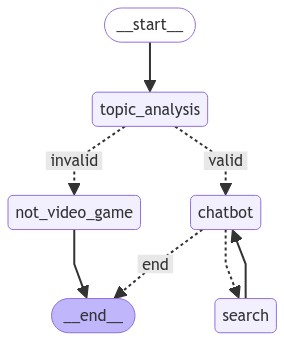

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [104]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            if isinstance(value["messages"][-1], AIMessage):
                print("Assistant:", value["messages"][-1].content)
            elif isinstance(value["messages"][-1], HumanMessage):
                print("Human:", value["messages"][-1].content)

--TOPIC ANALYSIS--
val=True
---DECISION: GENERATE SOLUTION---
Human: which pc games wre released in may 2024?
---DECISION: WEB SEARCH---
Assistant: 
--TOOL CALLED: tavily_search_results_json --
---DECISION: FINISH---
Assistant: I can't give you a specific list of PC games released in May 2024. My information is not up-to-date enough to provide that kind of information. You can find more details about game releases on websites like PC Gamer or Screenrant. 

Goodbye!


In [112]:
print(graph.invoke({"messages": ("user", "which model are you ?")})['messages'][-1].content)

--TOPIC ANALYSIS--
val=False
---DECISION: NOT VIDEO GAME---
I'm sorry, I can't help you with that. Please Ask me querys regarding video games.
